# Course: Data Analysis

# Topic 10: Time Series Analysis

* [Example 1: UFO Encounter Data (descriptive analysis)](#chapter1)
* [Example 2: Retail (interactive graphs) ](#chapter2)
* [Example 3: Missing values](#chapter3)
* [Example 4: Airline Passenger Data (ARIMA)](#chapter4)
* [Example 5: Salaries in Russia (SARIMA)](#chapter5)
* [Example 6: Macrodata (SARIMAX)](#chapter6)

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### White Noise

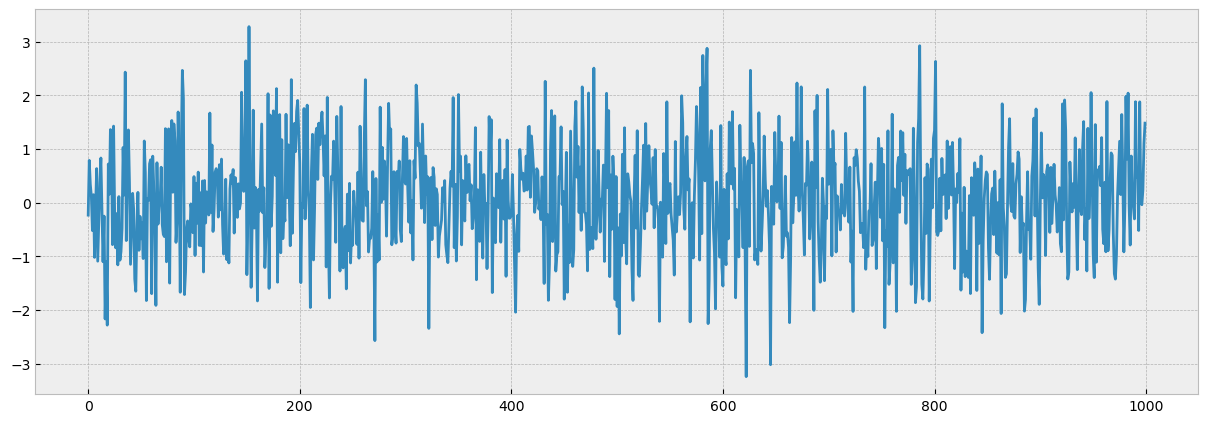

In [3]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

## Example 1: UFO Encounter Data <a class="anchor" id="chapter1"></a>

In [4]:
data = pd.read_csv('ufo.csv')
data.head()

City Colors Reported Shape Reported State             Time
0                Ithaca             NaN       TRIANGLE    NY   6/1/1930 22:00
1           Willingboro             NaN          OTHER    NJ  6/30/1930 20:00
2               Holyoke             NaN           OVAL    CO  2/15/1931 14:00
3               Abilene             NaN           DISK    KS   6/1/1931 13:00
4  New York Worlds Fair             NaN          LIGHT    NY  4/18/1933 19:00

In [5]:
data.info()  # time column is object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18241 entries, 0 to 18240
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   City             18215 non-null  object
 1   Colors Reported  2882 non-null   object
 2   Shape Reported   15597 non-null  object
 3   State            18241 non-null  object
 4   Time             18241 non-null  object
dtypes: object(5)
memory usage: 712.7+ KB


In [6]:
data['Time'][0]

'6/1/1930 22:00'

In [7]:
type(data['Time'][0])

str

In [8]:
data['Time'] = pd.to_datetime(data['Time'])  # convert to a format that allows to work with date and time
data['Time'][0]

Timestamp('1930-06-01 22:00:00')

In [9]:
type(data['Time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
data.head()

City Colors Reported Shape Reported State  \
0                Ithaca             NaN       TRIANGLE    NY   
1           Willingboro             NaN          OTHER    NJ   
2               Holyoke             NaN           OVAL    CO   
3               Abilene             NaN           DISK    KS   
4  New York Worlds Fair             NaN          LIGHT    NY   

                 Time  
0 1930-06-01 22:00:00  
1 1930-06-30 20:00:00  
2 1931-02-15 14:00:00  
3 1931-06-01 13:00:00  
4 1933-04-18 19:00:00

We can extract date and time parts from a datetime column, such as date, year, month, hours, minutes, etc.

In [11]:
data['Time'][0].year 

1930

In [12]:
data['Time'][0].month 

6

In [13]:
data['Time'][0].day 

1

In [14]:
data['Time'][0].hour

22

In [15]:
data['Time'][0].minute 

0

In [16]:
data['Time'][0].second 

0

In [17]:
data['Time'][0].week  # week number

22

In [18]:
data['Time'][0].day_name() 

'Sunday'

In [19]:
data['Time'].dt.year.head()  # column with years

0    1930
1    1930
2    1931
3    1931
4    1933
Name: Time, dtype: int32

In [20]:
data['Time'].dt.day_name().head() 

0     Sunday
1     Monday
2     Sunday
3     Monday
4    Tuesday
Name: Time, dtype: object

Number of UFOs in different years.

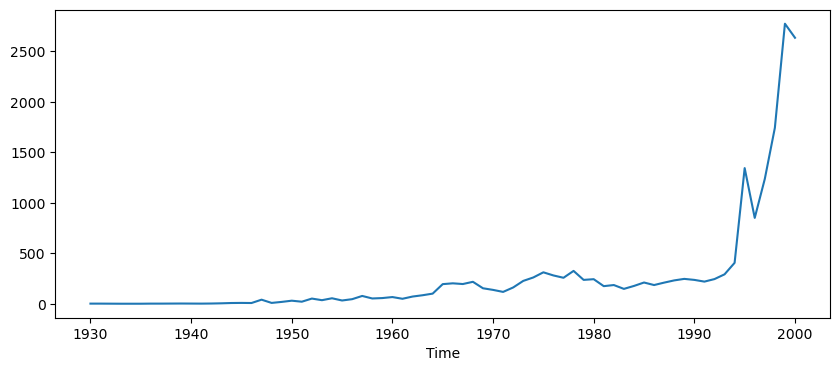

In [21]:
plt.figure(figsize=(10, 4))
data.groupby(data['Time'].dt.year).size().plot()
plt.show()

Number of UFOs by day of the week.

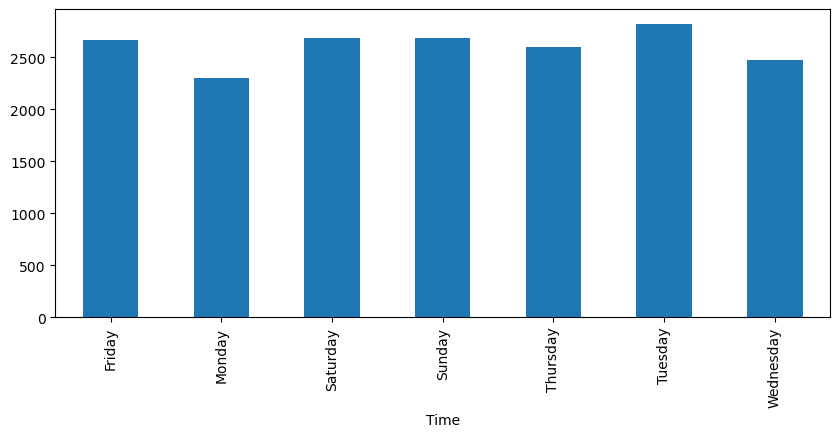

In [22]:
plt.figure(figsize=(10, 4))
data.groupby(data['Time'].dt.day_name()).size().plot(kind = 'bar')
plt.show()

Number of UFOs by hour.

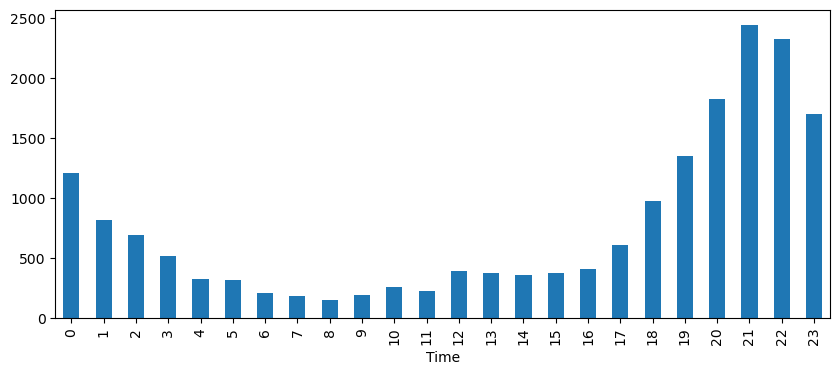

In [23]:
plt.figure(figsize=(10, 4))
data.groupby(data['Time'].dt.hour).size().plot(kind = 'bar')
plt.show()

Timestamp column can become an index.

In [24]:
data.index = data['Time']
data.head()

City Colors Reported Shape Reported  \
Time                                                                       
1930-06-01 22:00:00                Ithaca             NaN       TRIANGLE   
1930-06-30 20:00:00           Willingboro             NaN          OTHER   
1931-02-15 14:00:00               Holyoke             NaN           OVAL   
1931-06-01 13:00:00               Abilene             NaN           DISK   
1933-04-18 19:00:00  New York Worlds Fair             NaN          LIGHT   

                    State                Time  
Time                                           
1930-06-01 22:00:00    NY 1930-06-01 22:00:00  
1930-06-30 20:00:00    NJ 1930-06-30 20:00:00  
1931-02-15 14:00:00    CO 1931-02-15 14:00:00  
1931-06-01 13:00:00    KS 1931-06-01 13:00:00  
1933-04-18 19:00:00    NY 1933-04-18 19:00:00

In [25]:
data.loc["2000-06-01"].head(5)  # values for a specific date

City Colors Reported Shape Reported  \
Time                                                                            
2000-06-01 00:00:00  Joshua Tree National Park             NaN           OVAL   
2000-06-01 01:00:00                     Auburn             NaN           OVAL   
2000-06-01 02:00:00              San Francisco             NaN      FORMATION   
2000-06-01 12:00:00                   Powhatan             NaN          LIGHT   
2000-06-01 13:00:00                    Livonia             NaN           DISK   

                    State                Time  
Time                                           
2000-06-01 00:00:00    CA 2000-06-01 00:00:00  
2000-06-01 01:00:00    WA 2000-06-01 01:00:00  
2000-06-01 02:00:00    CA 2000-06-01 02:00:00  
2000-06-01 12:00:00    VA 2000-06-01 12:00:00  
2000-06-01 13:00:00    MI 2000-06-01 13:00:00

In [26]:
data.loc["June 1 2000"].head(5)  # the same result

City Colors Reported Shape Reported  \
Time                                                                            
2000-06-01 00:00:00  Joshua Tree National Park             NaN           OVAL   
2000-06-01 01:00:00                     Auburn             NaN           OVAL   
2000-06-01 02:00:00              San Francisco             NaN      FORMATION   
2000-06-01 12:00:00                   Powhatan             NaN          LIGHT   
2000-06-01 13:00:00                    Livonia             NaN           DISK   

                    State                Time  
Time                                           
2000-06-01 00:00:00    CA 2000-06-01 00:00:00  
2000-06-01 01:00:00    WA 2000-06-01 01:00:00  
2000-06-01 02:00:00    CA 2000-06-01 02:00:00  
2000-06-01 12:00:00    VA 2000-06-01 12:00:00  
2000-06-01 13:00:00    MI 2000-06-01 13:00:00

In [27]:
data.loc["June 2000"].head()  # values for a specific month

City Colors Reported Shape Reported  \
Time                                                                            
2000-06-01 00:00:00  Joshua Tree National Park             NaN           OVAL   
2000-06-01 01:00:00                     Auburn             NaN           OVAL   
2000-06-01 02:00:00              San Francisco             NaN      FORMATION   
2000-06-01 12:00:00                   Powhatan             NaN          LIGHT   
2000-06-01 13:00:00                    Livonia             NaN           DISK   

                    State                Time  
Time                                           
2000-06-01 00:00:00    CA 2000-06-01 00:00:00  
2000-06-01 01:00:00    WA 2000-06-01 01:00:00  
2000-06-01 02:00:00    CA 2000-06-01 02:00:00  
2000-06-01 12:00:00    VA 2000-06-01 12:00:00  
2000-06-01 13:00:00    MI 2000-06-01 13:00:00

## Example 2: Retail (interactive graphs) <a class="anchor" id="chapter2"></a>

In [28]:
df = pd.read_csv('retail.csv', sep = ';',parse_dates=['Date']).set_index('Date')
df.head(100)

Store_id  SKU_id  Promo  Demand  Regular_Price  Promo_Price
Date                                                                   
2015-01-01         1       1    NaN    22.0         163.78          NaN
2015-01-02         1       1    NaN    41.0         163.78          NaN
2015-01-03         1       1    NaN    35.0         163.78          NaN
2015-01-04         1       1    NaN    72.0         163.78          NaN
2015-01-05         1       1    NaN    25.0         163.78          NaN
...              ...     ...    ...     ...            ...          ...
2015-04-06         1       1    NaN   126.0         133.33          NaN
2015-04-07         1       1    1.0  1329.0         133.33       119.33
2015-04-08         1       1    1.0   996.0         133.33       119.33
2015-04-09         1       1    1.0  1100.0         133.33       119.33
2015-04-10         1       1    1.0   157.0         133.33       119.33

[100 rows x 6 columns]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92886 entries, 2015-01-01 to 2016-06-19
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store_id       92886 non-null  int64  
 1   SKU_id         92886 non-null  int64  
 2   Promo          16863 non-null  float64
 3   Demand         86916 non-null  float64
 4   Regular_Price  92886 non-null  float64
 5   Promo_Price    16863 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 5.0 MB


In [30]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

We can create different demand time-series graph for different combinations of store id and product id.

In [31]:
df[(df['Store_id']==1) & (df['SKU_id']==1)]['Demand'].plot().update_layout(height=350, width=1300).show()

In [32]:
df[(df['Store_id']==3) & (df['SKU_id']==2)]['Demand'].plot().update_layout(height=350, width=1300).show()

In [33]:
df = df[(df['Store_id'] == 1) & (df['SKU_id'] == 1)]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['Demand'], 
    mode='lines', 
    name='Demand'
))

fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['Regular_Price'], 
    mode='lines', 
    name='Regular Price',
    yaxis='y2' 
))

fig.update_layout(
    height=350,
    width=1300,
    title='Demand and Regular Price for Store 1, SKU 1',
    xaxis_title='Date',
    yaxis_title='Demand',
    yaxis2=dict(
        title='Regular Price',
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()

In [34]:
df = df[(df['Store_id'] == 1) & (df['SKU_id'] == 1)]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['Demand'], 
    mode='lines', 
    name='Demand'
))

fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['Promo'], 
    mode='lines', 
    name='Promo',
    yaxis='y2' 
))

fig.update_layout(
    height=350,
    width=1300,
    title='Demand and Promo for Store 1, SKU 1',
    xaxis_title='Date',
    yaxis_title='Demand',
    yaxis2=dict(
        title='Promo',
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99)
)

fig.show()

We can see a relationship between Promo and Demand.

## Example 3: Missing values <a class="anchor" id="chapter3"></a>

In [35]:
time_index = pd.date_range("1/01/2021", periods=6, freq="W")
df = pd.DataFrame(index=time_index);
print(df)
df["Sales"] = [5.0,4.0,np.nan,np.nan,1.0,np.nan];
print(df)

Empty DataFrame
Columns: []
Index: [2021-01-03 00:00:00, 2021-01-10 00:00:00, 2021-01-17 00:00:00, 2021-01-24 00:00:00, 2021-01-31 00:00:00, 2021-02-07 00:00:00]
            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    NaN
2021-01-24    NaN
2021-01-31    1.0
2021-02-07    NaN


In [36]:
# Interpolating missing values
df1= df.interpolate();
print(df1)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    3.0
2021-01-24    2.0
2021-01-31    1.0
2021-02-07    1.0


In [37]:
# Forward-fill Missing Values - Using value of next row to fill the missing value
df2 = df.ffill()
print(df2)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    4.0
2021-01-24    4.0
2021-01-31    1.0
2021-02-07    1.0


In [38]:
# Backfill Missing Values - Using value of previous row to fill the missing value
df3 = df.bfill();
print(df3)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    1.0
2021-01-24    1.0
2021-01-31    1.0
2021-02-07    NaN


In [39]:
# Interpolating Missing Values But Only Up One Value
df4 = df.interpolate(limit=1, limit_direction="forward");
print(df4)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    3.0
2021-01-24    NaN
2021-01-31    1.0
2021-02-07    1.0


In [40]:
# Interpolating Missing Values But Only Up Two Values
df5 = df.interpolate(limit=2, limit_direction="forward");
print(df5)

            Sales
2021-01-03    5.0
2021-01-10    4.0
2021-01-17    3.0
2021-01-24    2.0
2021-01-31    1.0
2021-02-07    1.0


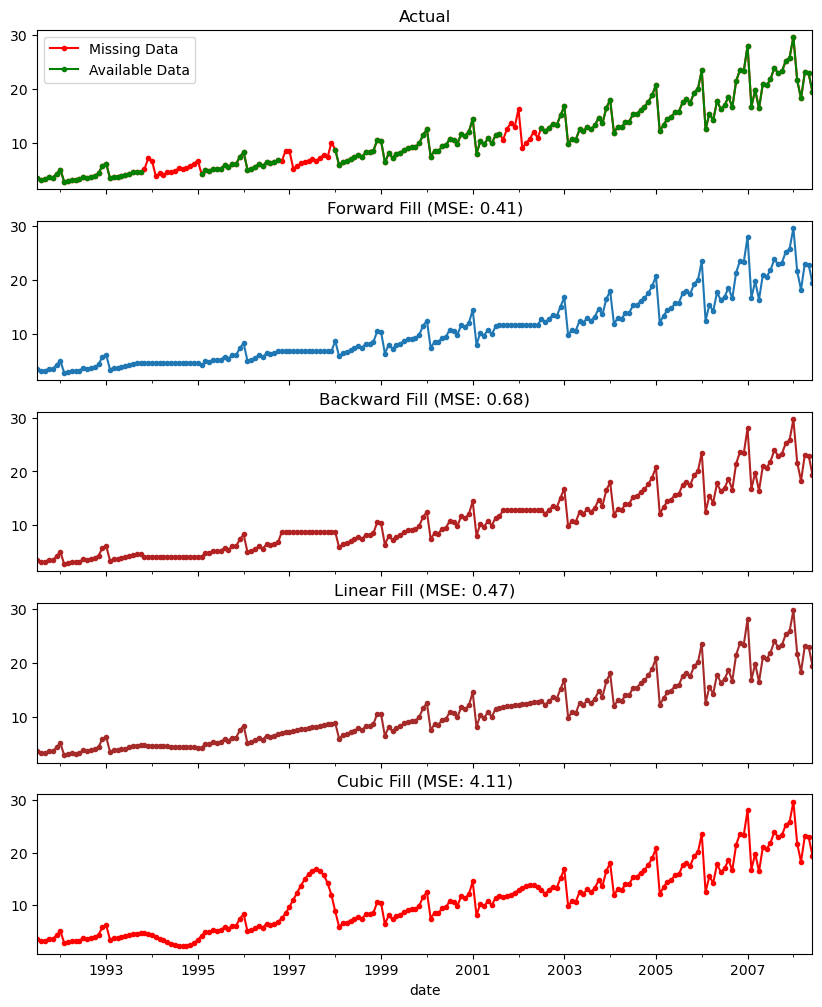

In [41]:
pd.options.plotting.backend = "matplotlib"

## Generate dataset
from scipy.interpolate import interp1d
df_orig = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
df = pd.read_csv('a10_missings.csv', parse_dates=['date'], index_col='date', sep=';')

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

# 1. Actual
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

# 2. Forward Fill
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) + ")", ax=axes[1], label='Forward Fill', style=".-")

# 3. Backward Fill
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) + ")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

# 4. Linear Interpolation
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset=['value'])
df_nona = df_nona.sort_values('rownum')

f = interp1d(df_nona['rownum'], df_nona['value'], kind='linear', fill_value='extrapolate')
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) + ")", ax=axes[3], label='Linear Fill', color='brown', style=".-")

# 5. Cubic Interpolation
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic', fill_value='extrapolate')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) + ")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

plt.show()
# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## Example 4: Airline Passenger Data <a class="anchor" id="chapter4"></a>

In [42]:
df = pd.read_csv("AirPassengers.csv")
df

Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


We can see that there is a column labeled `Month` that contains dates. In that column, the dates are formatted as year–month. We also see that the data starts in the year 1949. The second column is labeled `#Passengers`, and it contains the number of passengers for the year–month. 

Next we convert the month column into a datetime object. This will allow it to programmatically pull time values like the year or month for each record. To do this, we use the `to_datetime()` method. This process automatically inserts the first day of each month, which is basically a dummy value since we have no daily passenger data.

In [44]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m') 
df

Month  #Passengers
0   1949-01-01          112
1   1949-02-01          118
2   1949-03-01          132
3   1949-04-01          129
4   1949-05-01          121
..         ...          ...
139 1960-08-01          606
140 1960-09-01          508
141 1960-10-01          461
142 1960-11-01          390
143 1960-12-01          432

[144 rows x 2 columns]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


The next thing we can do is to convert the month column to an index. This will allow us to more easily work with some of the packages.

In [46]:
df.index = df['Month']
del df['Month']
df

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns]

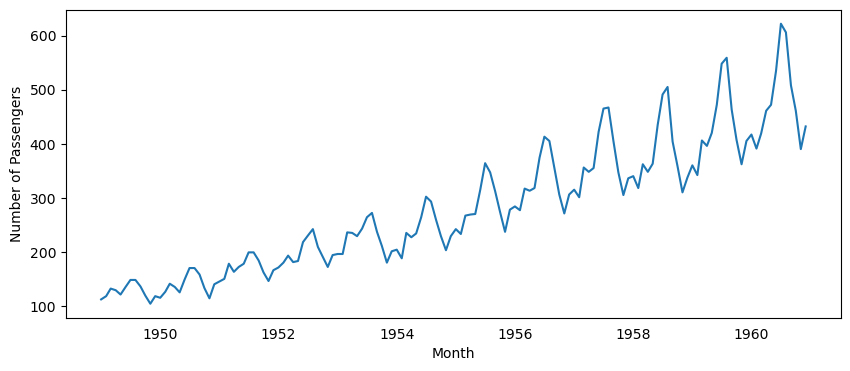

In [47]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x=df.index, y=df['#Passengers'])  # time series plot
plt.ylabel('Number of Passengers')
plt.show()

There is a trend and seasonality in the data.

### Time series decomposition

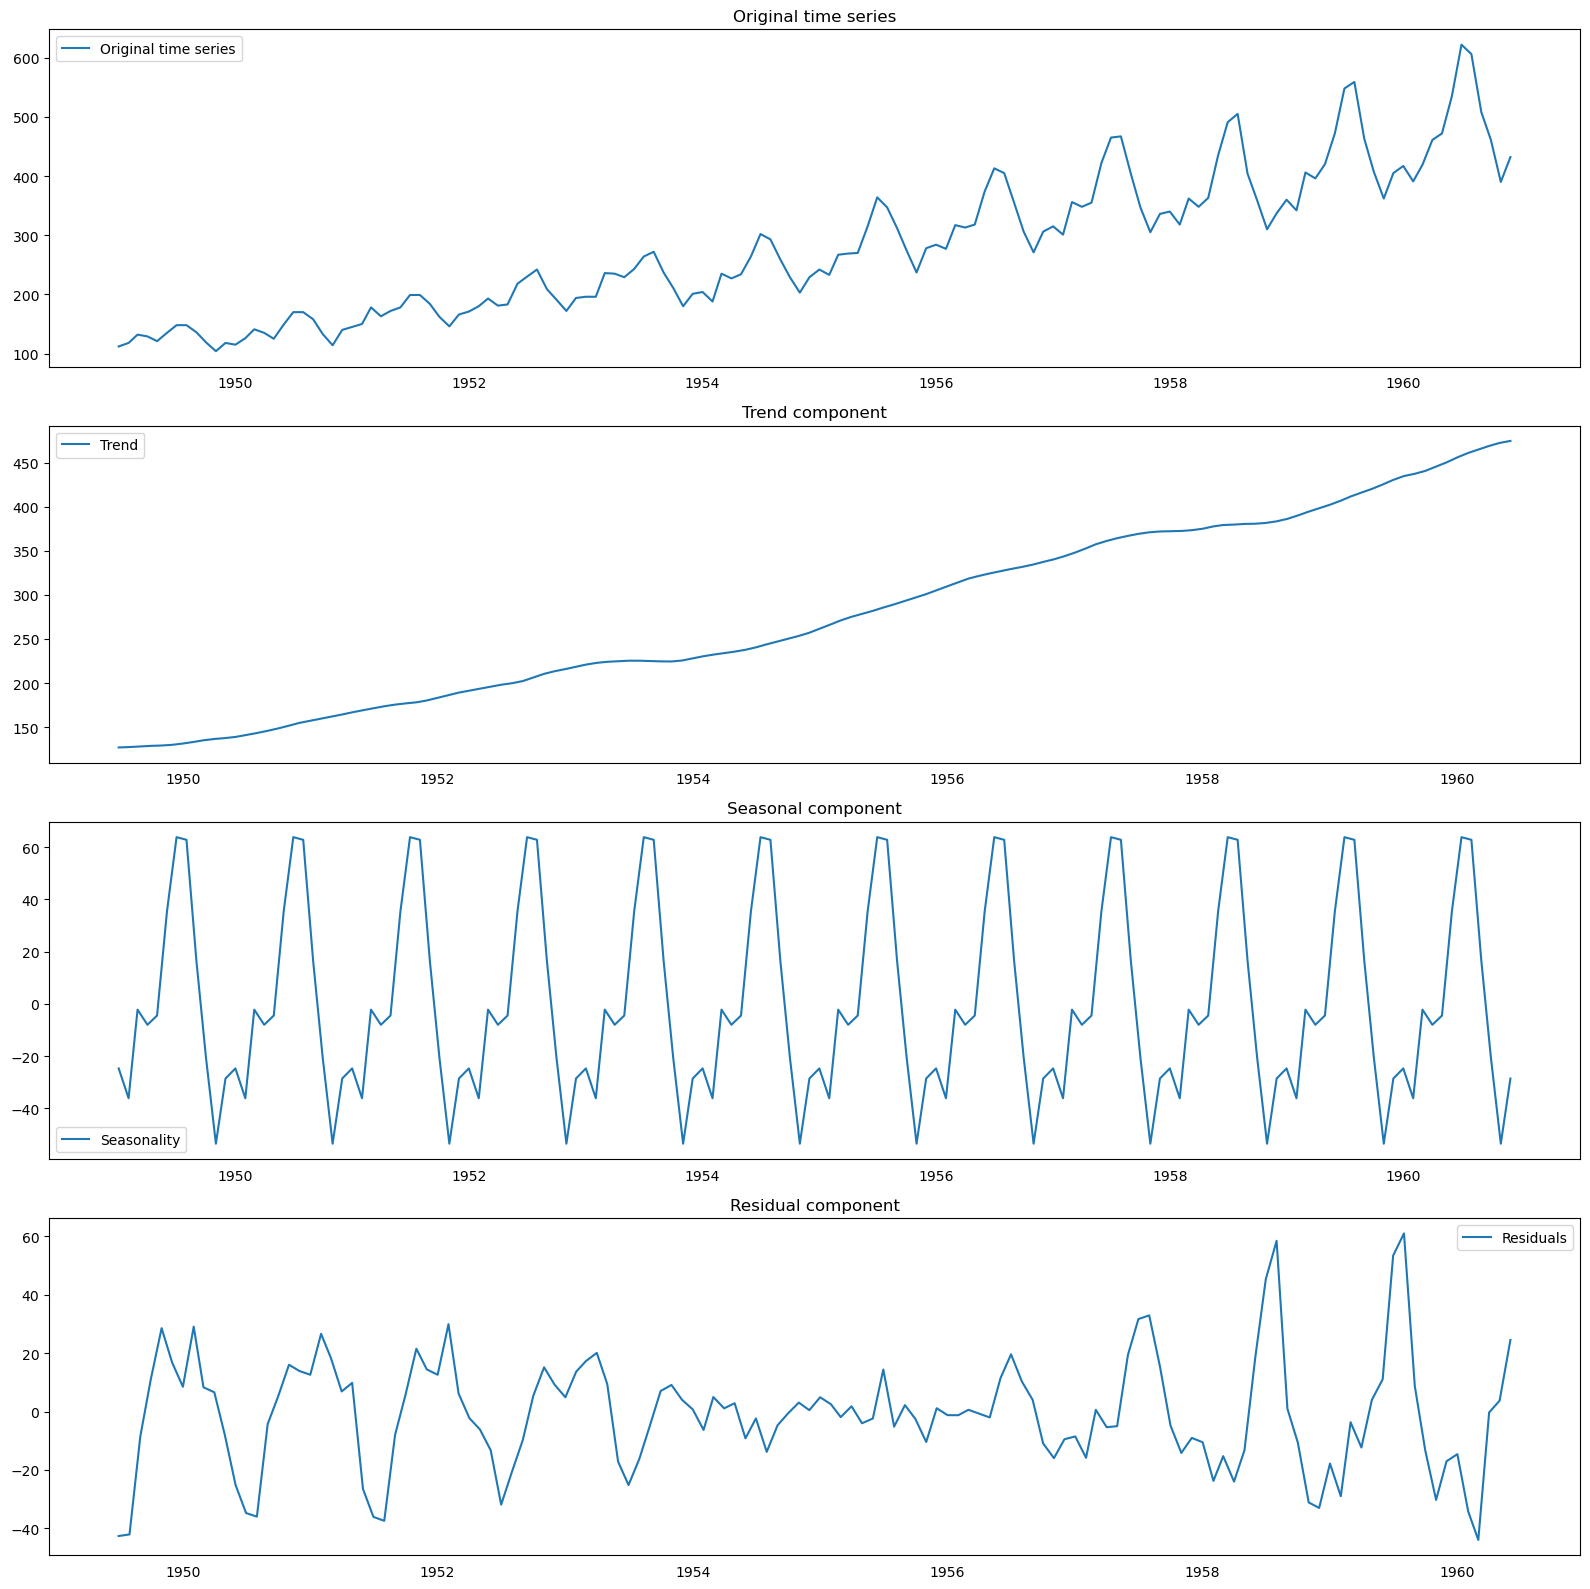

In [48]:
decomposition = seasonal_decompose(df, model='additive')

# Extracting trend, seasonality and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 16))

# Graph of the original time series
plt.subplot(411)
plt.plot(df.index, df['#Passengers'], label='Original time series')
plt.legend(loc='best')
plt.title('Original time series')

# Graph of the trend component
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.title('Trend component')

# Graph of the seasonal component 
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.title('Seasonal component')

# Residual component plot
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.title('Residual component')

plt.tight_layout()
plt.show()

### Moving average

Let’s overlay the time series with the seven-month rolling mean and seven-month rolling standard deviation.

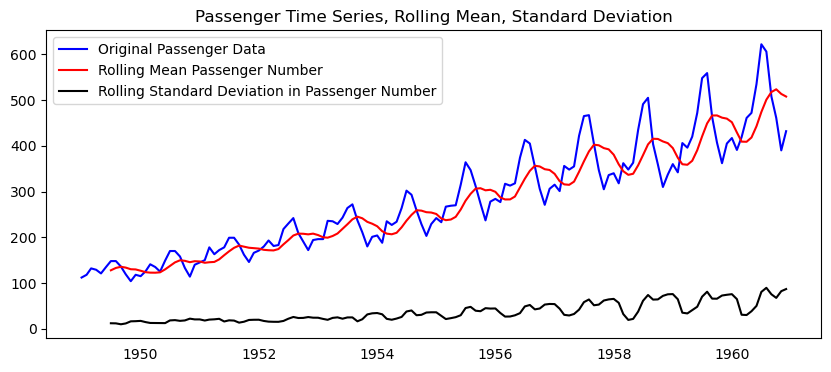

In [49]:
plt.figure(figsize=(10, 4))
plt.plot(df, color="blue",label="Original Passenger Data") 
rolling_mean = df.rolling(7).mean()  # 7-month rolling mean 
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number") 
rolling_std = df.rolling(7).std()  # 7-month rolling standard deviation
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

Now let's plot the twenty-month rolling mean.

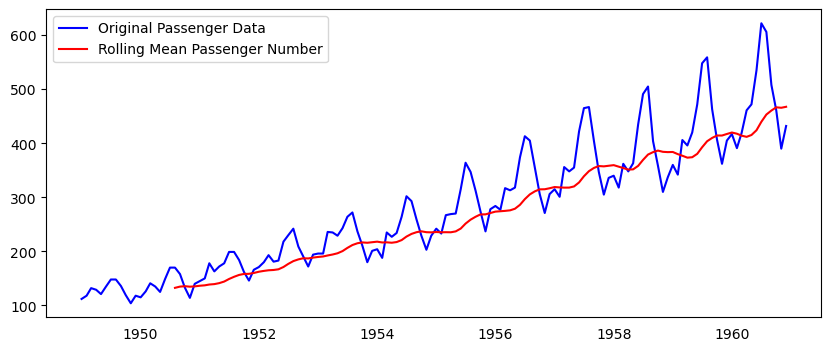

In [50]:
plt.figure(figsize=(10, 4))
plt.plot(df, color="blue",label="Original Passenger Data") 
rolling_mean = df.rolling(20).mean()  # 20-month rolling mean 
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number") 
plt.legend(loc="best")
plt.show()

### Stationarity

Stationarity is a key part of time series analysis. Stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. You should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including ARIMA.

### Dickey Fuller test 

This test will generate a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity.

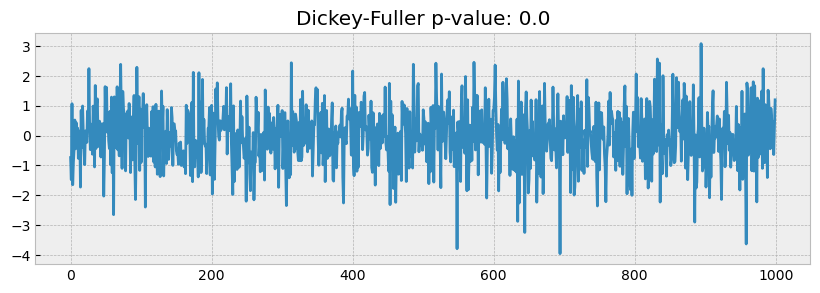

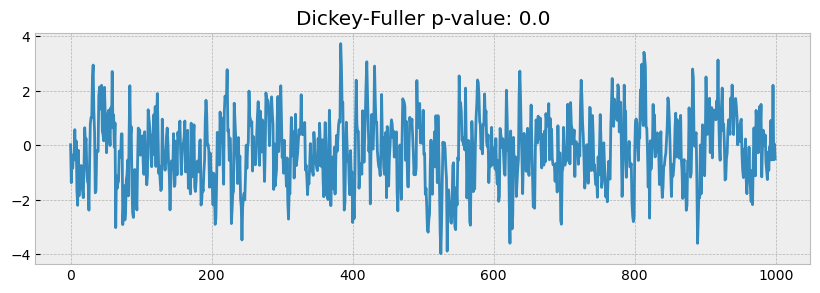

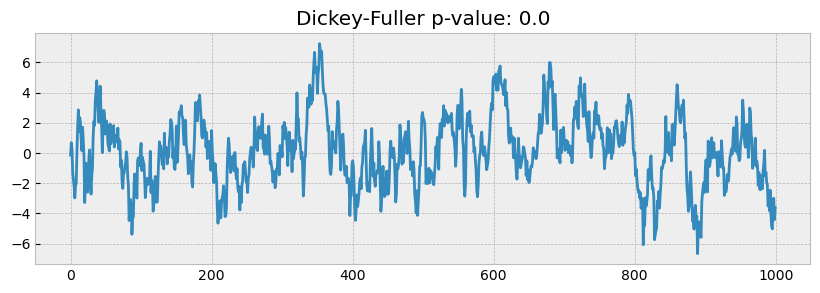

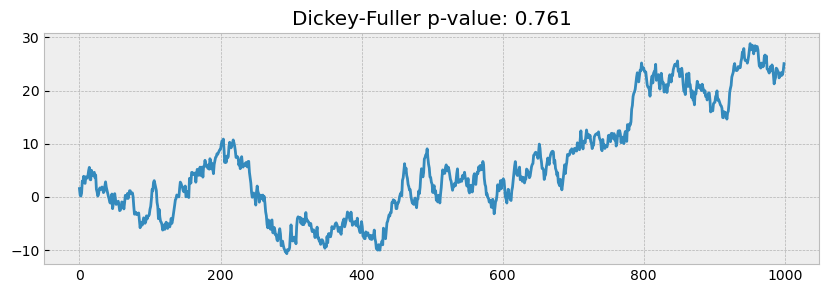

In [51]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(x)[1], 3)))
        plt.show()
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

In [52]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df,autolag="AIC")

In [53]:
print('p-value: ', adft[1])

p-value:  0.9918802434376409


We can see that our data is not stationary from the fact that our p-value is greater than 0.05.

In [54]:
df['#Passengers_dif1'] = df['#Passengers'] - df['#Passengers'].shift(1)  # one lag differencing
adft = adfuller(df['#Passengers_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.05421329028382621


After one lag differencing the p-value decreases.

In [55]:
df['#Passengers_dif2'] = df['#Passengers'] - df['#Passengers'].shift(2)  # two lags differencing
adft = adfuller(df['#Passengers_dif2'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.03862975767698843


After two lag differencing the series became stationary at the 5% significance level.

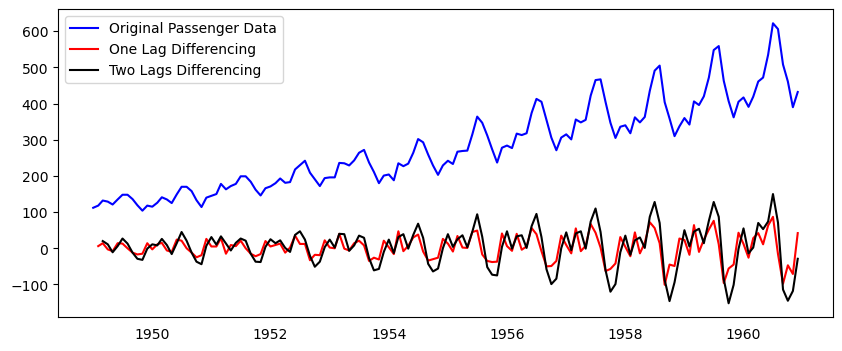

In [56]:
plt.figure(figsize=(10, 4))
plt.plot(df['#Passengers'], color="blue",label="Original Passenger Data")
plt.plot(df['#Passengers_dif1'], color="red", label="One Lag Differencing")
plt.plot(df['#Passengers_dif2'], color="black", label = "Two Lags Differencing") 
plt.legend(loc="best")
plt.show()

### Autocorrelation

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value. For example, if our passenger data has strong autocorrelation, we can assume that high passenger numbers today suggest a strong likelihood that they will be high tomorrow as well.

In [57]:
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.9601946480498524


In [58]:
autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6) 
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9) 
print("Nine Month Lag: ", autocorrelation_lag9)

autocorrelation_lag12 = df['#Passengers'].autocorr(lag=12) 
print("Twelve Month Lag: ", autocorrelation_lag12)

autocorrelation_lag18 = df['#Passengers'].autocorr(lag=18) 
print("Eighteen Month Lag: ", autocorrelation_lag18)

Three Month Lag:  0.8373947650817946
Six Month Lag:  0.7839187959206181
Nine Month Lag:  0.8278519011167608
Twelve Month Lag:  0.9905273692085446
Eighteen Month Lag:  0.7487523142605249


The data is highly autocorrelated. We see a very high autocorrelation of a twelve-month lag.

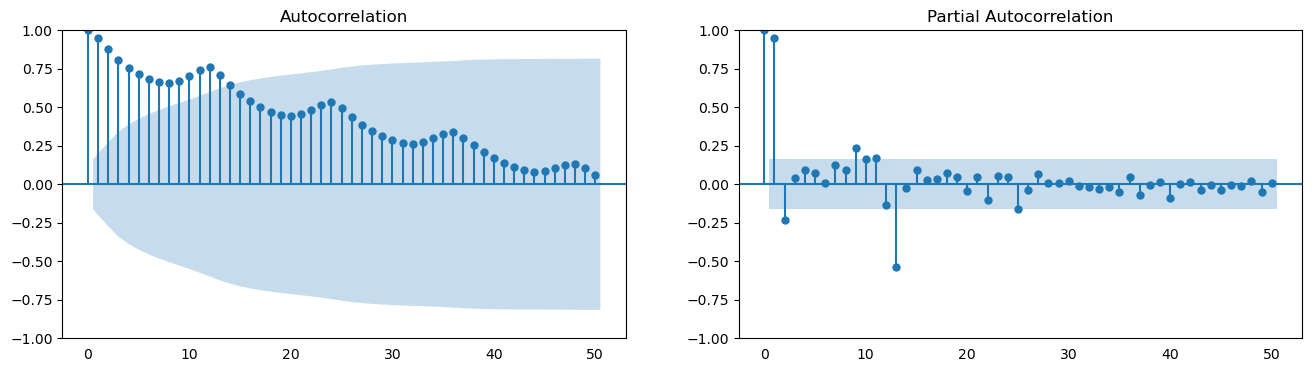

In [59]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df['#Passengers'], lags=50, ax=axes[0])
plot_pacf(df['#Passengers'], lags=50, ax=axes[1])
plt.show()

### Forecasting

Time series forecasting allows us to predict future values in a time series given current and past data. Here, we will use the ARIMA method to forecast the number of passengers, which allows us to forecast future values in terms of a linear combination of past values. First, let’s split our data for training and testing and visualize the split.

In [60]:
df = pd.read_csv("AirPassengers.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.index = df['Month']
del df['Month']

In [61]:
df['Date'] = df.index
train = df[df['Date'] < "1960-08"]
del train['Date']
train = train.rename(columns={'#Passengers': 'train'}) 
train

train
Month            
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
...           ...
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622

[139 rows x 1 columns]

In [62]:
test = df[df['Date'] >= "1960-08"]
del test['Date']
test = test.rename(columns={'#Passengers': 'test'}) 
test

test
Month           
1960-08-01   606
1960-09-01   508
1960-10-01   461
1960-11-01   390
1960-12-01   432

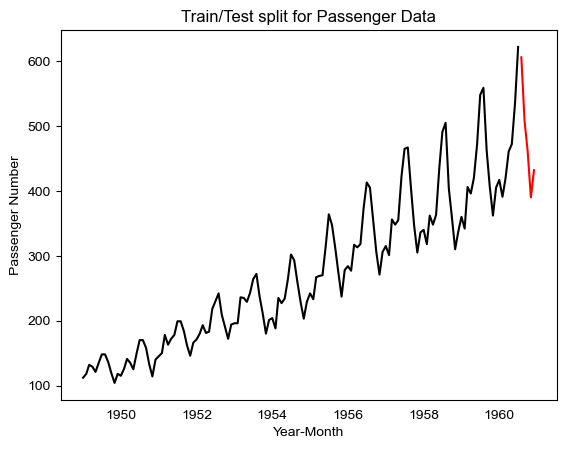

In [63]:
plt.plot(train, color = "black")
plt.plot(test, color = "red") 
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

The black line corresponds to our training data and the red line corresponds to our test data.

### ARIMA

In [64]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

We select a model with the lowest Akaike information criterion. Now, let’s display the output of our model.

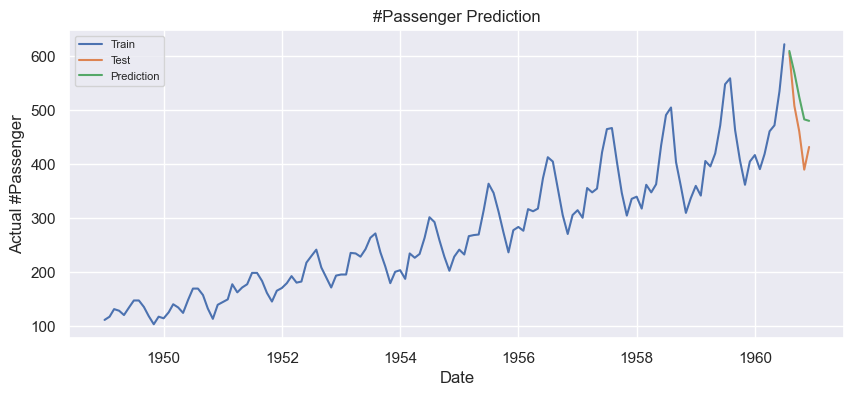

In [65]:
plt.figure(figsize=(10, 4))

plt.plot(train, label='Train') 
plt.plot(test, label='Test') 
plt.plot(forecast, label='Prediction') 

plt.title('#Passenger Prediction')
plt.xlabel('Date')
plt.ylabel('Actual #Passenger')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Our predictions are shown in green and the actual values are shown in orange.

In [66]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

Let's create a model with randomly selected parameters.

In [67]:
model  =  ARIMA(df['#Passengers'], order=(1, 1, 1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Mon, 10 Nov 2025   AIC                           1394.683
Time:                        12:57:47   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

In [68]:
predictions = res.predict(start=test.index[0], end=test.index[-1])
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3867.606400148482


In [69]:
model  =  ARIMA(df['#Passengers'], order=(4, 1, 3))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -674.913
Date:                Mon, 10 Nov 2025   AIC                           1365.825
Time:                        12:57:47   BIC                           1389.528
Sample:                    01-01-1949   HQIC                          1375.457
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238      0.128      0.970      0.3

In [70]:
predictions = res.predict(start=test.index[0], end=test.index[-1])
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 942.800831506053


Mean Squared Error decreased significantly.

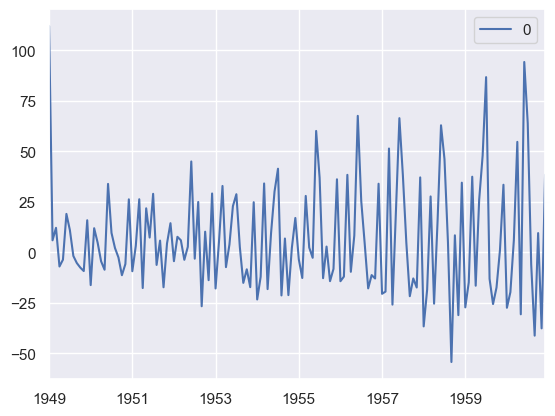

In [71]:
# Residuals
residuals = pd.DataFrame(res.resid)
residuals.plot()
plt.show()

No trend or seasonality in residuals, but the variance is increasing.

## Example 5: Salaries in Russia <a class="anchor" id="chapter5"></a>

In [72]:
df = pd.read_csv("monthly-wage.csv")
df

Month    Wage
0    1993-01  100.00
1    1993-02   99.04
2    1993-03  101.77
3    1993-04  110.05
4    1993-05  115.47
..       ...     ...
272  2015-09  220.90
273  2015-10  222.20
274  2015-11  220.70
275  2015-12  285.10
276  2016-01  209.00

[277 rows x 2 columns]

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   277 non-null    object 
 1   Wage    277 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.5+ KB


In [74]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df  # since the day of the month is not specified, the 1st is set everywhere

Month    Wage
0   1993-01-01  100.00
1   1993-02-01   99.04
2   1993-03-01  101.77
3   1993-04-01  110.05
4   1993-05-01  115.47
..         ...     ...
272 2015-09-01  220.90
273 2015-10-01  222.20
274 2015-11-01  220.70
275 2015-12-01  285.10
276 2016-01-01  209.00

[277 rows x 2 columns]

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   277 non-null    datetime64[ns]
 1   Wage    277 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.5 KB


In [76]:
df.index = df['Month']
del df['Month']
df

Wage
Month             
1993-01-01  100.00
1993-02-01   99.04
1993-03-01  101.77
1993-04-01  110.05
1993-05-01  115.47
...            ...
2015-09-01  220.90
2015-10-01  222.20
2015-11-01  220.70
2015-12-01  285.10
2016-01-01  209.00

[277 rows x 1 columns]

In [77]:
df.columns

Index(['Wage'], dtype='object')

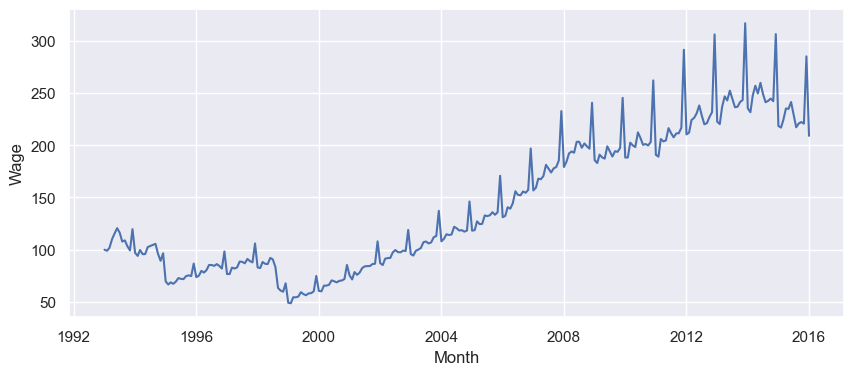

In [78]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x=df.index, y=df['Wage'])
plt.show()

There is a trend and seasonality in the data.

### Time series decomposition

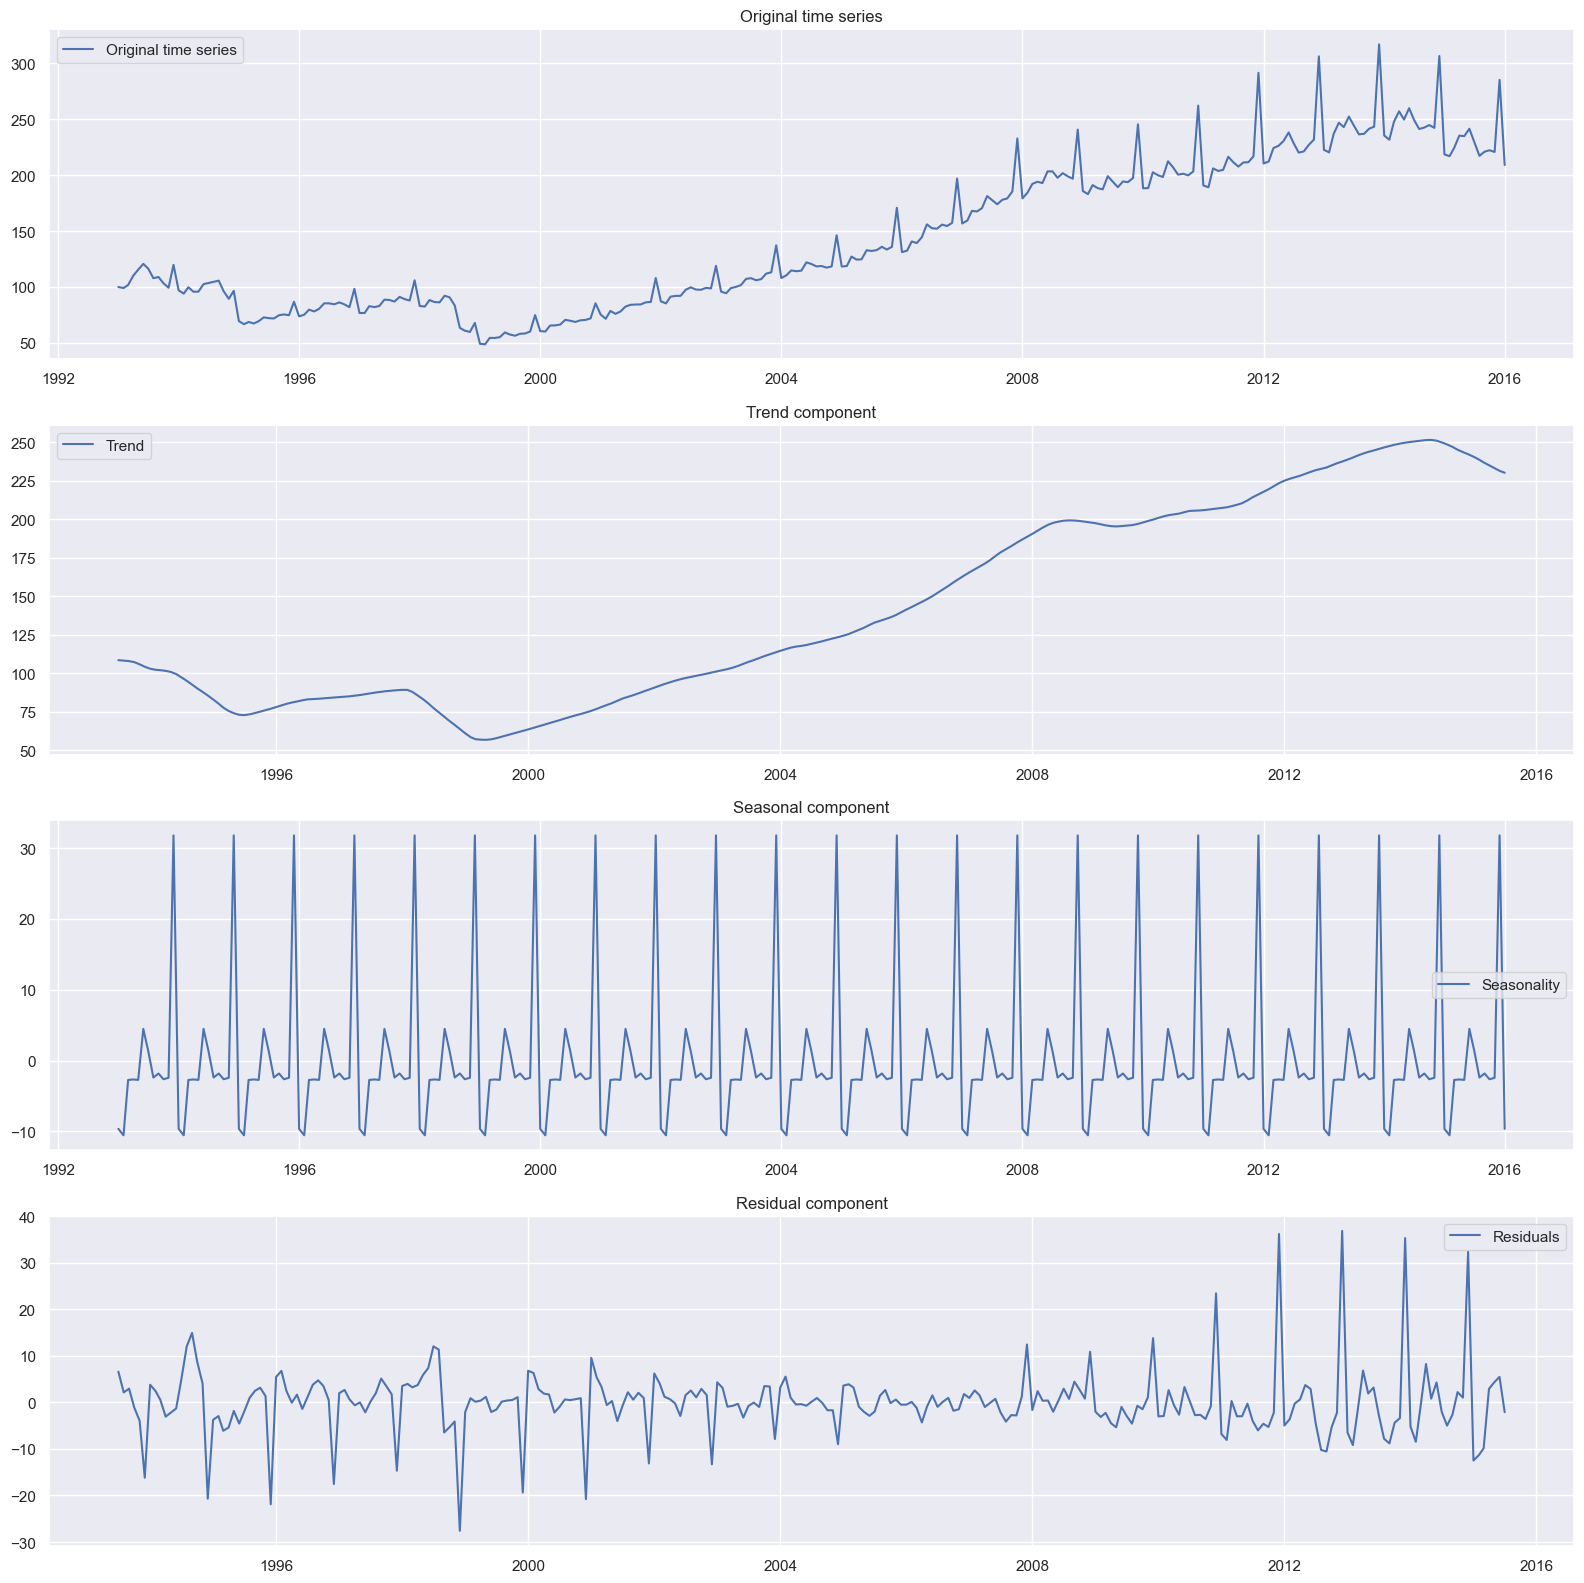

In [79]:
decomposition = seasonal_decompose(df, model='additive')

# Extracting trend, seasonality and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 16))

# Graph of the original time series
plt.subplot(411)
plt.plot(df.index, df['Wage'], label='Original time series')
plt.legend(loc='best')
plt.title('Original time series')

# Graph of the trend component
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.title('Trend component')

# Graph of the seasonal component 
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.title('Seasonal component')

# Residual component plot
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.title('Residual component')

plt.tight_layout()
plt.show()

In [80]:
adft = adfuller(df)
print('p-value: ', adft[1])

p-value:  0.9231115414958149


The series is not stationary, it contains a clear trend and seasonality.

In [81]:
df['Wage_dif1'] = df['Wage'] - df['Wage'].shift(1) 
adft = adfuller(df['Wage_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.008507613679230266


After one lag differencing the series became stationary at the 5% significance level.

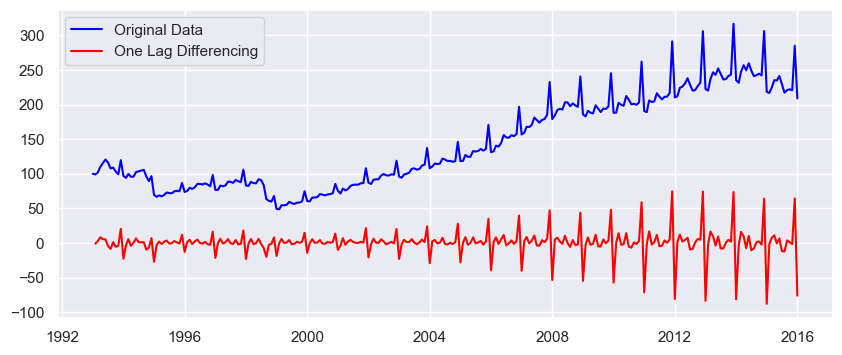

In [82]:
plt.figure(figsize=(10, 4))
plt.plot(df['Wage'], color="blue", label="Original Data")
plt.plot(df['Wage_dif1'], color="red", label="One Lag Differencing")
plt.legend(loc="best")
plt.show()

### Autocorrelation

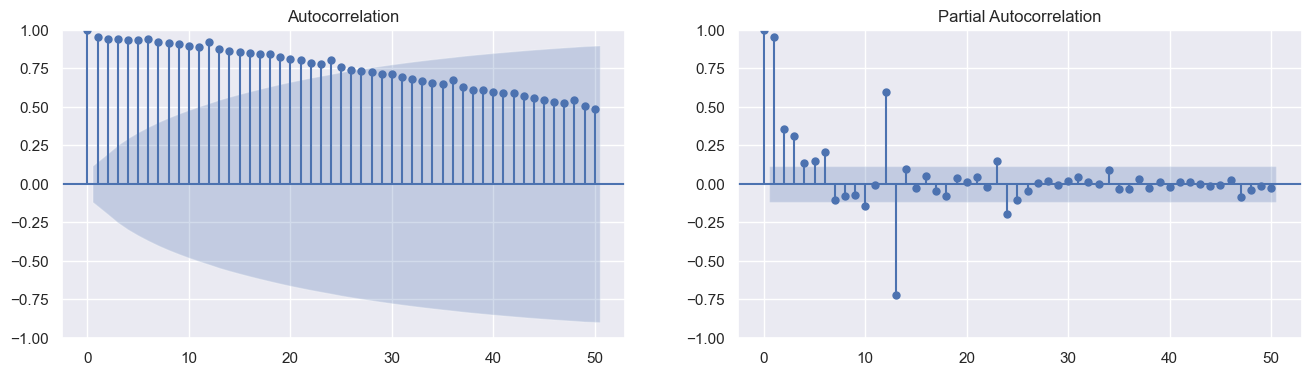

In [83]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df['Wage'], lags=50, ax=axes[0])
plot_pacf(df['Wage'], lags=50, ax=axes[1])
plt.show()

### Splitting series into train and test samples

Train sample: up to February 2013.

In [84]:
df = pd.read_csv("monthly-wage.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.index = df['Month']
del df['Month']

In [85]:
df['Date'] = df.index
train = df[df['Date'] < "2013-02"]
del train['Date']
train = train.rename(columns={'Wage': 'train'}) 
train

train
Month             
1993-01-01  100.00
1993-02-01   99.04
1993-03-01  101.77
1993-04-01  110.05
1993-05-01  115.47
...            ...
2012-09-01  221.20
2012-10-01  227.00
2012-11-01  231.70
2012-12-01  306.10
2013-01-01  222.60

[241 rows x 1 columns]

Test sample: the rest of the data

In [86]:
test = df[df['Date'] >= "2013-02"]
del test['Date']
test = test.rename(columns={'Wage': 'test'}) 
test

test
Month            
2013-02-01  220.3
2013-03-01  236.9
2013-04-01  246.8
2013-05-01  242.9
2013-06-01  252.3
2013-07-01  244.3
2013-08-01  236.4
2013-09-01  236.9
2013-10-01  241.4
2013-11-01  243.3
2013-12-01  316.8
2014-01-01  235.4
2014-02-01  231.6
2014-03-01  247.6
2014-04-01  257.0
2014-05-01  249.6
2014-06-01  259.8
2014-07-01  249.2
2014-08-01  241.2
2014-09-01  242.5
2014-10-01  244.7
2014-11-01  242.2
2014-12-01  306.4
2015-01-01  218.5
2015-02-01  216.9
2015-03-01  224.3
2015-04-01  235.3
2015-05-01  234.8
2015-06-01  241.4
2015-07-01  229.4
2015-08-01  217.2
2015-09-01  220.9
2015-10-01  222.2
2015-11-01  220.7
2015-12-01  285.1
2016-01-01  209.0

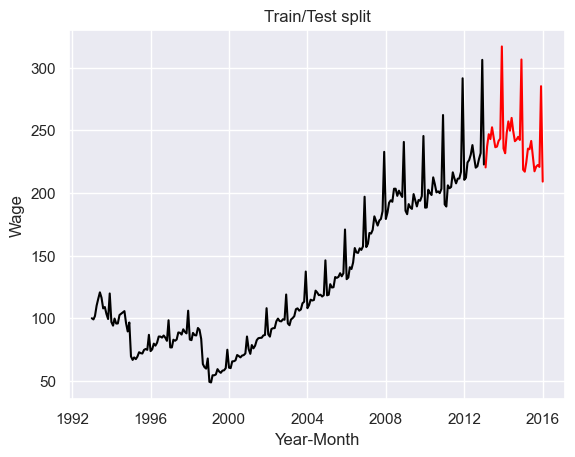

In [87]:
plt.plot(train, color = "black")  # train sample
plt.plot(test, color = "red")  # test sample 
plt.title("Train/Test split")
plt.ylabel("Wage")
plt.xlabel('Year-Month')
sns.set()
plt.show()

### ARIMA

In [88]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1938.598, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2042.880, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1986.388, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1937.805, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2041.099, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1939.112, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1938.793, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1941.702, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1940.840, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.463 seconds


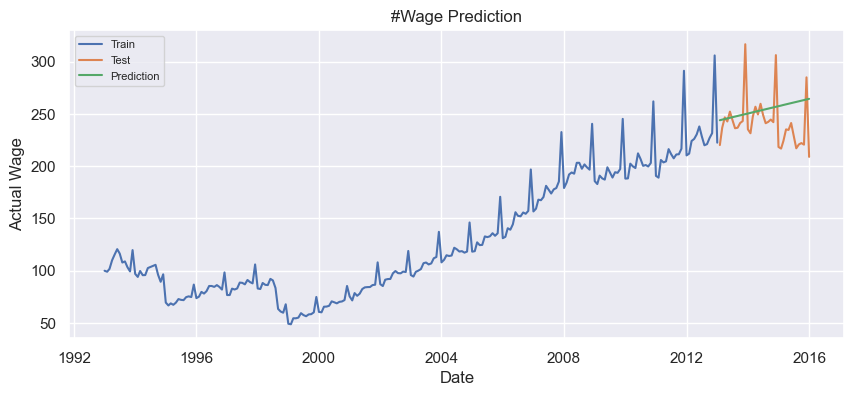

In [89]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') 
plt.plot(test, label='Test') 
plt.plot(forecast, label='Prediction') 

plt.title('#Wage Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Wage')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [90]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)

In [91]:
model  =  ARIMA(df['Wage'], order=(0, 1, 1))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   Wage   No. Observations:                  277
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1146.356
Date:                Mon, 10 Nov 2025   AIC                           2296.712
Time:                        12:57:57   BIC                           2303.953
Sample:                    01-01-1993   HQIC                          2299.618
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7372      0.036    -20.509      0.000      -0.808      -0.667
sigma2       236.5606      8.477     27.907      0.000     219.946     253.175
Ljung-Box (L1) (Q):                   0.99   Jarque-

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

def regression_quality_metrics_report(y_true, y_pred):
    
    rmse = np.sqrt( mean_squared_error(y_true, y_pred) )
    mae = mean_absolute_error(y_true, y_pred)
    rse = np.sqrt( ( (y_true - y_pred)**2 ).sum() / ( (y_true - y_true.mean())**2 ).sum() )
    rae = np.abs( y_true - y_pred ).sum() / np.abs( y_true - y_true.mean() ).sum()
    mape = 100. / len(y_true) * np.abs( 1. - y_pred/y_true ).sum()
    
    
    return [rmse, mae, rse, rae, mape]

In [93]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

metrics_report.loc['ARIMA', :] = regression_quality_metrics_report(test['test'].values, forecast['Prediction'].values)

metrics_report

RMSE       MAE       RSE       RAE      MAPE
ARIMA  27.370556  21.27147  1.228237  1.454183  8.949155

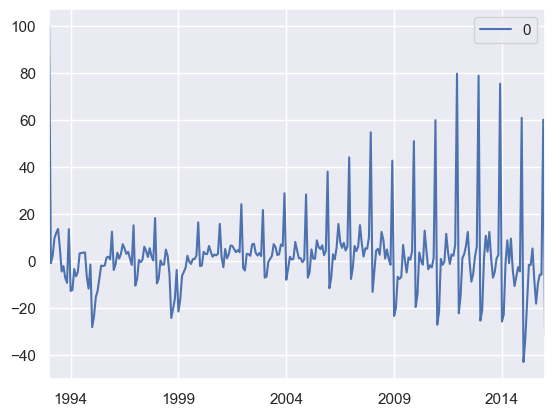

In [94]:
residuals = pd.DataFrame(res.resid)
residuals.plot()
plt.show()

Let's take into account the seasonal component.

In [95]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m=12)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1337.149, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1339.333, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1334.441, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1336.317, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1340.937, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1334.117, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1323.587, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1332.729, Time=0.22 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=1306.047, Time=0.79 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=1334.690, Time=0.33 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1336.310, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1304.073, Time=0.73 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1332.757, Time=0.29 sec
 ARIMA(0,1,0)(1,1,1)[12]

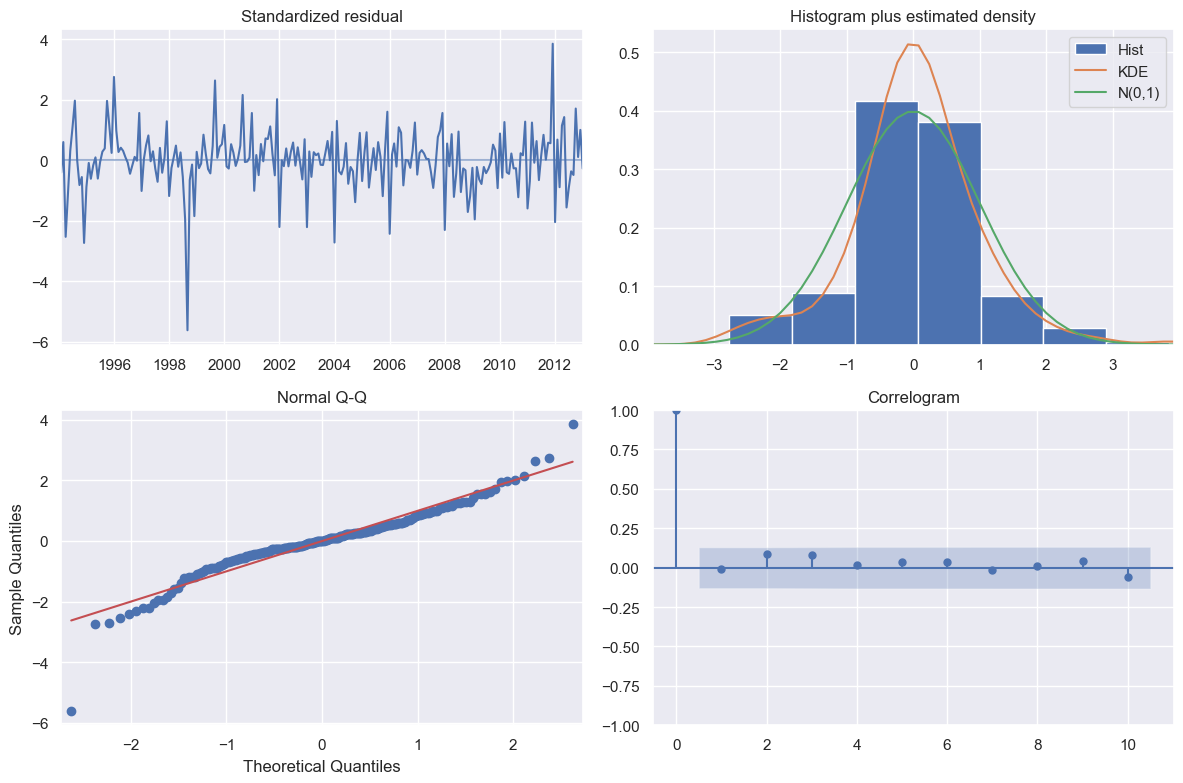

In [96]:
model.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [97]:
model  =  ARIMA(df['Wage'], order=(0, 1, 0), seasonal_order=(1, 1, 2, 12))
res = model.fit()
print(res.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                  Wage   No. Observations:                  277
Model:             ARIMA(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -763.249
Date:                               Mon, 10 Nov 2025   AIC                           1534.499
Time:                                       12:58:13   BIC                           1548.803
Sample:                                   01-01-1993   HQIC                          1540.247
                                        - 01-01-2016                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8020      0.108      7.403      0.000       0.590       1.014
ma.S.L12   

In [98]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

metrics_report.loc['SARIMA', :] = regression_quality_metrics_report(test['test'].values, forecast['Prediction'].values)

metrics_report

RMSE        MAE       RSE       RAE      MAPE
SARIMA  20.051685  13.772878  0.899807  0.941556  5.812545

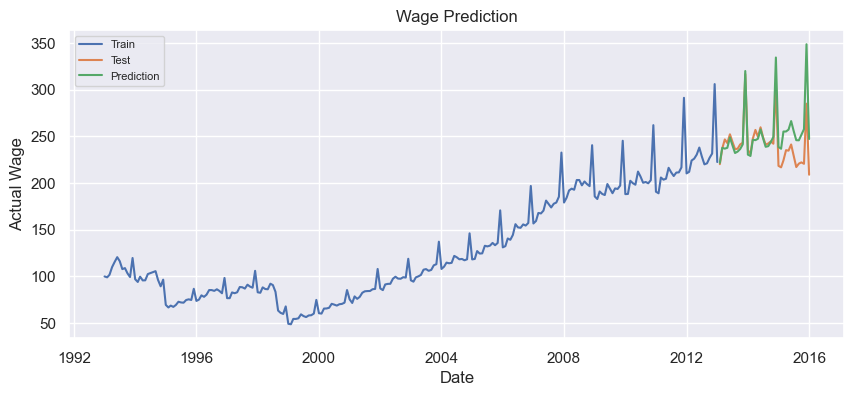

In [99]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train') 
plt.plot(test, label='Test') 
plt.plot(forecast, label='Prediction') 

plt.title('Wage Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Wage')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Example 6: Macrodata (SARIMAX) <a class="anchor" id="chapter6"></a>

| Variable     | Description                                                       |
| ------------ | ----------------------------------------------------------------- |
| **year**     | Year of the observation                                           |
| **quarter**  | Quarter of the year (1 to 4)                                      |
| **realgdp**  | Real Gross Domestic Product (GDP), inflation-adjusted             |
| **realcons** | Real Personal Consumption Expenditures (consumption)              |
| **realinv**  | Real Gross Private Domestic Investment                            |
| **realgovt** | Real Government Expenditures                                      |
| **realdpi**  | Real Disposable Personal Income                                   |
| **cpi**      | Consumer Price Index                                              |
| **m1**       | Money supply M1 (currency in circulation + demand deposits)       |
| **tbilrate** | 3-month Treasury Bill interest rate                               |
| **unemp**    | Unemployment rate (percentage)                                    |
| **pop**      | Population (in millions)                                          |
| **infl**     | Inflation rate (percentage change in CPI)                         |
| **realint**  | Real interest rate (nominal interest rate adjusted for inflation) |


In [100]:
df = sm.datasets.macrodata.load_pandas().data 
df

year  quarter    realgdp  realcons   realinv  realgovt  realdpi  \
0    1959.0      1.0   2710.349    1707.4   286.898   470.045   1886.9   
1    1959.0      2.0   2778.801    1733.7   310.859   481.301   1919.7   
2    1959.0      3.0   2775.488    1751.8   289.226   491.260   1916.4   
3    1959.0      4.0   2785.204    1753.7   299.356   484.052   1931.3   
4    1960.0      1.0   2847.699    1770.5   331.722   462.199   1955.5   
..      ...      ...        ...       ...       ...       ...      ...   
198  2008.0      3.0  13324.600    9267.7  1990.693   991.551   9838.3   
199  2008.0      4.0  13141.920    9195.3  1857.661  1007.273   9920.4   
200  2009.0      1.0  12925.410    9209.2  1558.494   996.287   9926.4   
201  2009.0      2.0  12901.504    9189.0  1456.678  1023.528  10077.5   
202  2009.0      3.0  12990.341    9256.0  1486.398  1044.088  10040.6   

         cpi      m1  tbilrate  unemp      pop  infl  realint  
0     28.980   139.7      2.82    5.8  177.146  0.00     0.00  
1     29.150   141.7      3.08    5.1  177.830  2.34     0.74  
2     29.350   140.5      3.82    5.3  178.657  2.74     1.09  
3     29.370   140.0      4.33    5.6  179.386  0.27     4.06  
4     29.540   139.6      3.50    5.2  180.007  2.31     1.19  
..       ...     ...       ...    ...      ...   ...      ...  
198  216.889  1474.7      1.17    6.0  305.270 -3.16     4.33  
199  212.174  1576.5      0.12    6.9  305.952 -8.79     8.91  
200  212.671  1592.8      0.22    8.1  306.547  0.94    -0.71  
201  214.469  1653.6      0.18    9.2  307.226  3.37    -3.19  
202  216.385  1673.9      0.12    9.6  308.013  3.56    -3.44  

[203 rows x 14 columns]

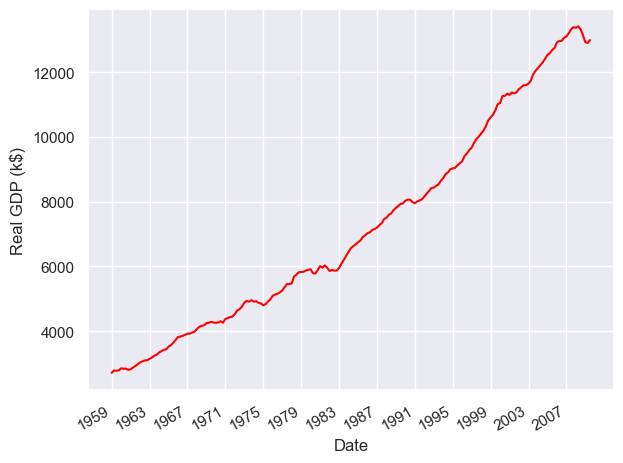

In [101]:
fig, ax = plt.subplots()

ax.plot(df['realgdp'], color = "red")
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Splitting series into train and test samples

Train sample: up to 2000.

In [102]:
df

year  quarter    realgdp  realcons   realinv  realgovt  realdpi  \
0    1959.0      1.0   2710.349    1707.4   286.898   470.045   1886.9   
1    1959.0      2.0   2778.801    1733.7   310.859   481.301   1919.7   
2    1959.0      3.0   2775.488    1751.8   289.226   491.260   1916.4   
3    1959.0      4.0   2785.204    1753.7   299.356   484.052   1931.3   
4    1960.0      1.0   2847.699    1770.5   331.722   462.199   1955.5   
..      ...      ...        ...       ...       ...       ...      ...   
198  2008.0      3.0  13324.600    9267.7  1990.693   991.551   9838.3   
199  2008.0      4.0  13141.920    9195.3  1857.661  1007.273   9920.4   
200  2009.0      1.0  12925.410    9209.2  1558.494   996.287   9926.4   
201  2009.0      2.0  12901.504    9189.0  1456.678  1023.528  10077.5   
202  2009.0      3.0  12990.341    9256.0  1486.398  1044.088  10040.6   

         cpi      m1  tbilrate  unemp      pop  infl  realint  
0     28.980   139.7      2.82    5.8  177.146  0.00     0.00  
1     29.150   141.7      3.08    5.1  177.830  2.34     0.74  
2     29.350   140.5      3.82    5.3  178.657  2.74     1.09  
3     29.370   140.0      4.33    5.6  179.386  0.27     4.06  
4     29.540   139.6      3.50    5.2  180.007  2.31     1.19  
..       ...     ...       ...    ...      ...   ...      ...  
198  216.889  1474.7      1.17    6.0  305.270 -3.16     4.33  
199  212.174  1576.5      0.12    6.9  305.952 -8.79     8.91  
200  212.671  1592.8      0.22    8.1  306.547  0.94    -0.71  
201  214.469  1653.6      0.18    9.2  307.226  3.37    -3.19  
202  216.385  1673.9      0.12    9.6  308.013  3.56    -3.44  

[203 rows x 14 columns]

In [103]:
df['year'] = df['year'].astype(int)
df['quarter'] = df['quarter'].astype(int)
df['date'] = df['year'].astype(str) + 'Q' + df['quarter'].astype(str)
df['date'] = pd.PeriodIndex(df['date'], freq='Q').to_timestamp()
df = df.set_index('date').sort_index()
df

year  quarter    realgdp  realcons   realinv  realgovt  realdpi  \
date                                                                          
1959-01-01  1959        1   2710.349    1707.4   286.898   470.045   1886.9   
1959-04-01  1959        2   2778.801    1733.7   310.859   481.301   1919.7   
1959-07-01  1959        3   2775.488    1751.8   289.226   491.260   1916.4   
1959-10-01  1959        4   2785.204    1753.7   299.356   484.052   1931.3   
1960-01-01  1960        1   2847.699    1770.5   331.722   462.199   1955.5   
...          ...      ...        ...       ...       ...       ...      ...   
2008-07-01  2008        3  13324.600    9267.7  1990.693   991.551   9838.3   
2008-10-01  2008        4  13141.920    9195.3  1857.661  1007.273   9920.4   
2009-01-01  2009        1  12925.410    9209.2  1558.494   996.287   9926.4   
2009-04-01  2009        2  12901.504    9189.0  1456.678  1023.528  10077.5   
2009-07-01  2009        3  12990.341    9256.0  1486.398  1044.088  10040.6   

                cpi      m1  tbilrate  unemp      pop  infl  realint  
date                                                                  
1959-01-01   28.980   139.7      2.82    5.8  177.146  0.00     0.00  
1959-04-01   29.150   141.7      3.08    5.1  177.830  2.34     0.74  
1959-07-01   29.350   140.5      3.82    5.3  178.657  2.74     1.09  
1959-10-01   29.370   140.0      4.33    5.6  179.386  0.27     4.06  
1960-01-01   29.540   139.6      3.50    5.2  180.007  2.31     1.19  
...             ...     ...       ...    ...      ...   ...      ...  
2008-07-01  216.889  1474.7      1.17    6.0  305.270 -3.16     4.33  
2008-10-01  212.174  1576.5      0.12    6.9  305.952 -8.79     8.91  
2009-01-01  212.671  1592.8      0.22    8.1  306.547  0.94    -0.71  
2009-04-01  214.469  1653.6      0.18    9.2  307.226  3.37    -3.19  
2009-07-01  216.385  1673.9      0.12    9.6  308.013  3.56    -3.44  

[203 rows x 14 columns]

In [104]:
df['year'] = df.index
train = df[df['year'] < "2000-01"]
del train['year']
train

quarter    realgdp  realcons   realinv  realgovt  realdpi     cpi  \
date                                                                            
1959-01-01        1   2710.349    1707.4   286.898   470.045   1886.9   28.98   
1959-04-01        2   2778.801    1733.7   310.859   481.301   1919.7   29.15   
1959-07-01        3   2775.488    1751.8   289.226   491.260   1916.4   29.35   
1959-10-01        4   2785.204    1753.7   299.356   484.052   1931.3   29.37   
1960-01-01        1   2847.699    1770.5   331.722   462.199   1955.5   29.54   
...             ...        ...       ...       ...       ...      ...     ...   
1998-10-01        4  10507.575    7019.1  1754.743   688.147   7646.5  164.70   
1999-01-01        1  10601.179    7088.3  1809.993   683.601   7698.4  165.90   
1999-04-01        2  10684.049    7199.9  1803.674   683.594   7716.0  166.70   
1999-07-01        3  10819.914    7286.4  1848.949   697.936   7765.9  168.10   
1999-10-01        4  11014.254    7389.2  1914.567   713.445   7887.7  169.30   

                m1  tbilrate  unemp      pop  infl  realint  
date                                                         
1959-01-01   139.7      2.82    5.8  177.146  0.00     0.00  
1959-04-01   141.7      3.08    5.1  177.830  2.34     0.74  
1959-07-01   140.5      3.82    5.3  178.657  2.74     1.09  
1959-10-01   140.0      4.33    5.6  179.386  0.27     4.06  
1960-01-01   139.6      3.50    5.2  180.007  2.31     1.19  
...            ...       ...    ...      ...   ...      ...  
1998-10-01  1097.8      4.38    4.4  277.790  1.95     2.43  
1999-01-01  1101.9      4.39    4.3  278.451  2.90     1.49  
1999-04-01  1098.7      4.54    4.3  279.295  1.92     2.62  
1999-07-01  1102.3      4.75    4.2  280.203  3.35     1.41  
1999-10-01  1121.9      5.20    4.1  280.976  2.85     2.35  

[164 rows x 13 columns]

In [105]:
test = df[df['year'] >= "2000-01"]
del test['year']
test

quarter    realgdp  realcons   realinv  realgovt  realdpi  \
date                                                                    
2000-01-01        1  11043.044    7501.3  1887.836   685.216   8053.4   
2000-04-01        2  11258.454    7571.8  2018.529   712.641   8135.9   
2000-07-01        3  11267.867    7645.9  1986.956   698.827   8222.3   
2000-10-01        4  11334.544    7713.5  1987.845   695.597   8234.6   
2001-01-01        1  11297.171    7744.3  1882.691   710.403   8296.5   
2001-04-01        2  11371.251    7773.5  1876.650   725.623   8273.7   
2001-07-01        3  11340.075    7807.7  1837.074   730.493   8484.5   
2001-10-01        4  11380.128    7930.0  1731.189   739.318   8385.5   
2002-01-01        1  11477.868    7957.3  1789.327   756.915   8611.6   
2002-04-01        2  11538.770    7997.8  1810.779   774.408   8658.9   
2002-07-01        3  11596.430    8052.0  1814.531   786.673   8629.2   
2002-10-01        4  11598.824    8080.6  1813.219   799.967   8649.6   
2003-01-01        1  11645.819    8122.3  1813.141   800.196   8681.3   
2003-04-01        2  11738.706    8197.8  1823.698   838.775   8812.5   
2003-07-01        3  11935.461    8312.1  1889.883   839.598   8935.4   
2003-10-01        4  12042.817    8358.0  1959.783   845.722   8986.4   
2004-01-01        1  12127.623    8437.6  1970.015   856.570   9025.9   
2004-04-01        2  12213.818    8483.2  2055.580   861.440   9115.0   
2004-07-01        3  12303.533    8555.8  2082.231   876.385   9175.9   
2004-10-01        4  12410.282    8654.2  2125.152   865.596   9303.4   
2005-01-01        1  12534.113    8719.0  2170.299   869.204   9189.6   
2005-04-01        2  12587.535    8802.9  2131.468   870.044   9253.0   
2005-07-01        3  12683.153    8865.6  2154.949   890.394   9308.0   
2005-10-01        4  12748.699    8888.5  2232.193   875.557   9358.7   
2006-01-01        1  12915.938    8986.6  2264.721   900.511   9533.8   
2006-04-01        2  12962.462    9035.0  2261.247   892.839   9617.3   
2006-07-01        3  12965.916    9090.7  2229.636   892.002   9662.5   
2006-10-01        4  13060.679    9181.6  2165.966   894.404   9788.8   
2007-01-01        1  13099.901    9265.1  2132.609   882.766   9830.2   
2007-04-01        2  13203.977    9291.5  2162.214   898.713   9842.7   
2007-07-01        3  13321.109    9335.6  2166.491   918.983   9883.9   
2007-10-01        4  13391.249    9363.6  2123.426   925.110   9886.2   
2008-01-01        1  13366.865    9349.6  2082.886   943.372   9826.8   
2008-04-01        2  13415.266    9351.0  2026.518   961.280  10059.0   
2008-07-01        3  13324.600    9267.7  1990.693   991.551   9838.3   
2008-10-01        4  13141.920    9195.3  1857.661  1007.273   9920.4   
2009-01-01        1  12925.410    9209.2  1558.494   996.287   9926.4   
2009-04-01        2  12901.504    9189.0  1456.678  1023.528  10077.5   
2009-07-01        3  12990.341    9256.0  1486.398  1044.088  10040.6   

                cpi      m1  tbilrate  unemp      pop  infl  realint  
date                                                                  
2000-01-01  170.900  1113.5      5.63    4.0  281.653  3.76     1.87  
2000-04-01  172.700  1103.0      5.81    3.9  282.385  4.19     1.62  
2000-07-01  173.900  1098.7      6.07    4.0  283.190  2.77     3.30  
2000-10-01  175.600  1097.7      5.70    3.9  283.900  3.89     1.81  
2001-01-01  176.400  1114.9      4.39    4.2  284.550  1.82     2.57  
2001-04-01  177.400  1139.7      3.54    4.4  285.267  2.26     1.28  
2001-07-01  177.600  1166.0      2.72    4.8  286.047  0.45     2.27  
2001-10-01  177.700  1190.9      1.74    5.5  286.728  0.23     1.51  
2002-01-01  179.300  1185.9      1.75    5.7  287.328  3.59    -1.84  
2002-04-01  180.000  1199.5      1.70    5.8  288.028  1.56     0.14  
2002-07-01  181.200  1204.0      1.61    5.7  288.783  2.66    -1.05  
2002-10-01  182.600  1226.8      1.20    5.8  289.421  3.08    -1.88  
2003-01-01  183.200  124

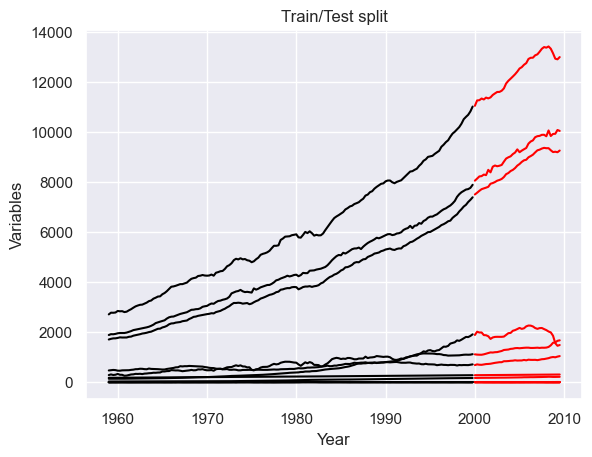

In [106]:
plt.plot(train, color = "black")  # train sample
plt.plot(test, color = "red")  # test sample 
plt.title("Train/Test split")
plt.ylabel("Variables")
plt.xlabel('Year')
sns.set()
plt.show()

### ARIMA

In [107]:
model = auto_arima(train['realgdp'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train['realgdp'])
forecast = model.predict(n_periods=len(test['realgdp']))
forecast = pd.DataFrame(forecast, index = test['realgdp'].index, columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=1720.704, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1771.804, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1742.352, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1724.443, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1718.882, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1722.112, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1719.246, Time=0.03 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=1720.732, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=1720.041, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1718.717, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1737.658, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1720.713, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1732.963, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1722.649, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept

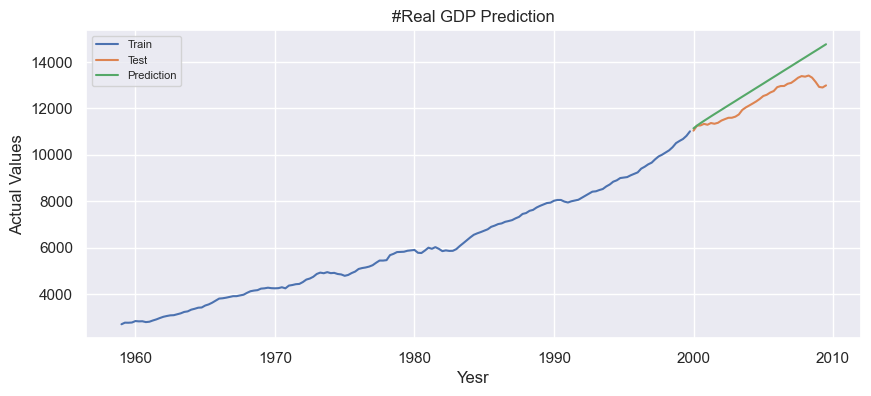

In [108]:
plt.figure(figsize=(10, 4))
plt.plot(train['realgdp'], label='Train') 
plt.plot(test['realgdp'], label='Test') 
plt.plot(forecast, label='Prediction') 

plt.title('#Real GDP Prediction')
plt.xlabel('Yesr')
plt.ylabel('Actual Values')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [109]:
def regression_quality_metrics_report(y_true, y_pred):
    
    rmse = np.sqrt( mean_squared_error(y_true, y_pred) )
    mae = mean_absolute_error(y_true, y_pred)
    rse = np.sqrt( ( (y_true - y_pred)**2 ).sum() / ( (y_true - y_true.mean())**2 ).sum() )
    rae = np.abs( y_true - y_pred ).sum() / np.abs( y_true - y_true.mean() ).sum()
    mape = 100. / len(y_true) * np.abs( 1. - y_pred/y_true ).sum()
    
    
    return [rmse, mae, rse, rae, mape]

In [110]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

metrics_report.loc['ARIMA', :] = regression_quality_metrics_report(test['realgdp'].values, forecast['Prediction'].values)

metrics_report

RMSE         MAE      RSE       RAE      MAPE
ARIMA  763.515317  653.591537  0.99633  0.939929  5.196348

### SARIMAX

In [111]:
target = df['realgdp']
exog = df[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

train_end = '2000-12-31'

train_target = target.loc[:train_end]
test_target = target.loc[train_end:]

train_exog = exog.loc[:train_end]
test_exog = exog.loc[train_end:]

In [112]:
auto_model = auto_arima(train_target,
                        exogenous=train_exog,
                        seasonal=True, m=4,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=1778.290, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=1842.401, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=1800.441, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=1780.885, Time=0.03 sec
 ARIMA(2,2,2)(0,0,1)[4]             : AIC=1776.260, Time=0.28 sec
 ARIMA(2,2,2)(0,0,0)[4]             : AIC=1774.642, Time=0.09 sec
 ARIMA(2,2,2)(1,0,0)[4]             : AIC=1776.375, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[4]             : AIC=1774.144, Time=0.08 sec
 ARIMA(1,2,2)(1,0,0)[4]             : AIC=1775.975, Time=0.13 sec
 ARIMA(1,2,2)(0,0,1)[4]             : AIC=1775.898, Time=0.12 sec
 ARIMA(1,2,2)(1,0,1)[4]             : AIC=1780.850, Time=0.20 sec
 ARIMA(0,2,2)(0,0,0)[4]             : AIC=1778.295, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=1776.291, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[4]             : AIC=1780.616, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[4]          

In [113]:
model = SARIMAX(train_target,
                exog=train_exog,
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  168
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -698.733
Date:                Mon, 10 Nov 2025   AIC                           1415.465
Time:                        12:58:17   BIC                           1443.364
Sample:                    01-01-1959   HQIC                          1426.791
                         - 10-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.8806      0.059     14.853      0.000       0.764       0.997
realinv        1.0622      0.036     29.883      0.000       0.992       1.132
realgovt       0.7428      0.131      5.682      0.0

In [114]:
forecast = results.get_forecast(steps=len(test_target), exog=test_exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

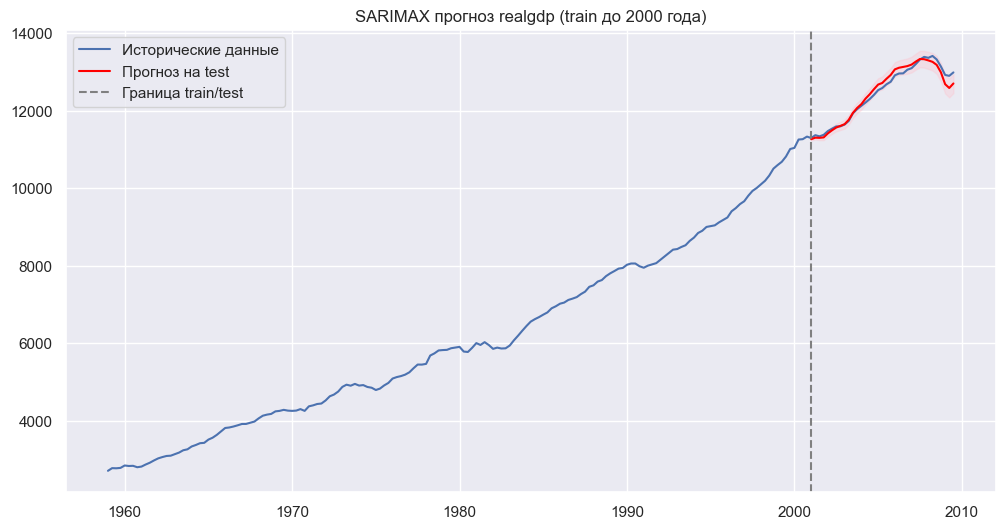

In [115]:
plt.figure(figsize=(12,6))
plt.plot(target, label='Исторические данные')
plt.plot(forecast_mean, label='Прогноз на test', color='red')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.axvline(pd.Timestamp(train_end), color='gray', linestyle='--', label='Граница train/test')
plt.title('SARIMAX прогноз realgdp (train до 2000 года)')
plt.legend()
plt.show()

In [116]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

metrics_report.loc['SARIMAX'] = regression_quality_metrics_report(test_target.values, forecast_mean.values)

metrics_report

RMSE         MAE       RSE       RAE      MAPE
SARIMAX  126.560136  101.905252  0.178858  0.160745  0.802538